In [10]:
# Step 1: Load the dataset
file_path = "/content/drive/MyDrive/dataset/(6)Supplemental_data_tang_1st - CTLThompson.csv.csv.csv"
df = pd.read_csv(file_path)

df.head()
#df.tail()

,Test Type,Soil Type,Shaft Shape,Shaft diameter(mm),Depth (m),Age(days),Rum(kN),Number of Helix,Effective Helix Diameter,T(kN.m)
0,C,Clay,SS,38,8.8,13,237,1,203,7.5
1,C,Clay,SS,38,7.3,7,222,1,203,8.1
2,C,Clay,SS,38,5.8,29,81,1,203,2.2
3,C,Clay,SS,38,5.8,6,245,1,203,8.1
4,C,Clay,SS,38,4.3,6,68,1,203,2.2


In [19]:
# === Imports ===
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler
from sklearn.metrics import r2_score

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor

# === Load Dataset ===
data = pd.read_csv('/content/drive/MyDrive/dataset/(6)Supplemental_data_tang_1st - CTLThompson.csv.csv.csv')

# === Encode Categorical Variables ===
for col in ['Test Type', 'Soil Type', 'Shaft Shape']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# === Define Features and Target ===
X = data.drop(columns=['T(kN.m)'])
y = data['T(kN.m)']

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# === Scaling for Models that Require It ===
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Initialize Dictionary for R² Scores ===
models = {}

# === 1. XGBoost Regressor ===
xgb_params = {
    'n_estimators': 1000,
    'max_depth': 8,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'gamma': 0.1,
    'random_state': 42
}
xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
models['XGBoost'] = r2_score(y_test, y_pred_xgb)

# === 2. Random Forest Regressor ===
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
models['Random Forest'] = r2_score(y_test, y_pred_rf)

# === 3. Support Vector Regression ===
svr = SVR(kernel='rbf', C=1000, gamma=0.1)
svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_test_scaled)
models['SVR (RBF)'] = r2_score(y_test, y_pred_svr)

# === 4. Decision Tree Regressor ===
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
models['Decision Tree'] = r2_score(y_test, y_pred_dt)

# === 5. SGD Regressor (Corrected with Robust Scaling) ===

# 1. Use more robust feature scaling
feature_scaler = StandardScaler()  # Switch to StandardScaler for better gradient behavior
X_train_sgd = feature_scaler.fit_transform(X_train)
X_test_sgd = feature_scaler.transform(X_test)

# 2. Scale target variable
target_scaler = StandardScaler()
y_train_sgd = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# 3. Configure SGD with careful settings
sgd = SGDRegressor(
    loss='huber',                  # More robust to outliers
    penalty='elasticnet',          # Combination of L1 and L2 regularization
    alpha=0.0001,                  # Very small regularization strength
    l1_ratio=0.5,                  # Balance between L1/L2
    max_iter=5000,                 # Increased iterations
    tol=1e-5,                      # Stricter convergence tolerance
    learning_rate='invscaling',    # Decreasing learning rate over time
    eta0=0.0001,                   # Very small initial learning rate
    power_t=0.25,                  # Aggressive decay rate
    early_stopping=True,           # Stop if no improvement
    validation_fraction=0.2,       # Larger validation set
    random_state=42
)

# 4. Fit with convergence monitoring
sgd.fit(X_train_sgd, y_train_sgd)

# 5. Predict and inverse transform
y_pred_sgd_scaled = sgd.predict(X_test_sgd)
y_pred_sgd = target_scaler.inverse_transform(y_pred_sgd_scaled.reshape(-1, 1)).ravel()

# 6. Handle potential negative values (if any)
y_pred_sgd = np.abs(y_pred_sgd)  # Force positive predictions if your target can't be negative

# 7. Calculate R² score
models['SGD Regressor'] = r2_score(y_test, y_pred_sgd)

# Print convergence status
print(f"SGD converged: {sgd.n_iter_ < sgd.max_iter}")
print(f"Final learning rate: {sgd.t_:.6f}")

# === 6. Linear Regression ===
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
models['Linear Regression'] = r2_score(y_test, y_pred_lr)

# === 7. Ridge Regression ===
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)
models['Ridge Regression'] = r2_score(y_test, y_pred_ridge)

# === 8. Lasso Regression ===
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)
models['Lasso Regression'] = r2_score(y_test, y_pred_lasso)

# === 9. Elastic Net Regression ===
enet = ElasticNet(alpha=0.1, l1_ratio=0.5)
enet.fit(X_train_scaled, y_train)
y_pred_enet = enet.predict(X_test_scaled)
models['Elastic Net'] = r2_score(y_test, y_pred_enet)

# === 10. Neural Network (MLP Regressor) ===
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                   max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)
y_pred_mlp = mlp.predict(X_test_scaled)
models['Neural Network (MLP)'] = r2_score(y_test, y_pred_mlp)

# === 11. AdaBoost Regressor ===
ada = AdaBoostRegressor(n_estimators=200, random_state=42)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
models['AdaBoost'] = r2_score(y_test, y_pred_ada)

# === 12. Naive Bayes (adapted with binned target) ===

# Step 1: Define bins and bin target
bins = np.linspace(y.min(), y.max(), 11)  # 10 bins => 11 edges
y_binned = np.digitize(y, bins, right=True)

# Step 2: Compute bin centers for mapping predicted classes back
bin_centers = (bins[:-1] + bins[1:]) / 2

# Step 3: Prevent index overflow (e.g., when y == max(y), it can fall out of range)
# np.digitize returns values from 1 to len(bins), so subtract 1 to make it 0-indexed
y_binned = np.clip(y_binned - 1, 0, len(bin_centers) - 1)

# Step 4: Split the data for classification task
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X, y_binned, test_size=0.15, random_state=42)

# Step 5: Train Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train_nb, y_train_nb)

# Step 6: Predict class labels
y_pred_classes = gnb.predict(X_test_nb)

# Step 7: Map predicted class labels to corresponding bin centers
y_pred_nb = bin_centers[y_pred_classes]

# Step 8: Convert y_test_nb to actual values using bin centers (optional, for fair R²)
y_test_actual = bin_centers[y_test_nb]

# Step 9: Evaluate performance
models['Naive Bayes (binned)'] = r2_score(y_test_actual, y_pred_nb)


# === Print All R² Scores ===
print("\nModel Performance (R² Scores):")
for name, score in models.items():
    print(f"{name}: {score:.3f}")

SGD converged: False
Final learning rate: 4800001.000000

Model Performance (R² Scores):
XGBoost: 0.983
Random Forest: 0.957
SVR (RBF): 0.956
Decision Tree: 0.957
SGD Regressor: 0.755
Linear Regression: 0.819
Ridge Regression: 0.819
Lasso Regression: 0.805
Elastic Net: 0.807
Neural Network (MLP): 0.852
AdaBoost: 0.769
Naive Bayes (binned): 0.274


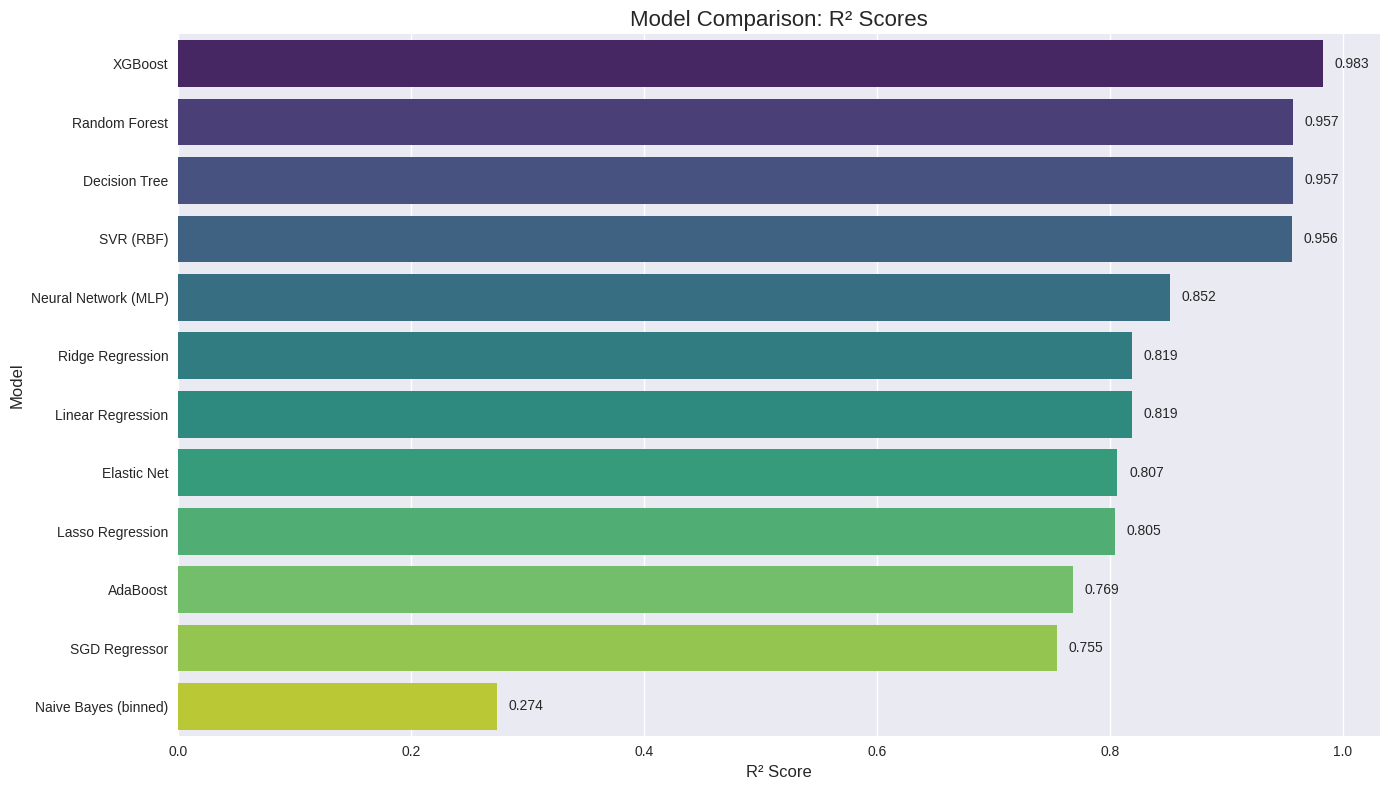

+----------------------+---------------------+----------------------+
|        Model         |      R² Score       | Performance Category |
+----------------------+---------------------+----------------------+
|       XGBoost        | 0.9829897187469538  |   Excellent (>0.9)   |
|    Random Forest     | 0.9574066495665408  |   Excellent (>0.9)   |
|    Decision Tree     | 0.9573746618083955  |   Excellent (>0.9)   |
|      SVR (RBF)       | 0.9563213629803962  |   Excellent (>0.9)   |
| Neural Network (MLP) | 0.8517042842599823  |    Good (0.8-0.9)    |
|   Ridge Regression   | 0.8187733817755192  |    Good (0.8-0.9)    |
|  Linear Regression   |  0.818735784461584  |    Good (0.8-0.9)    |
|     Elastic Net      | 0.8067007229102392  |    Good (0.8-0.9)    |
|   Lasso Regression   | 0.8047516699110757  |    Good (0.8-0.9)    |
|       AdaBoost       | 0.7686234572092795  |  Moderate (0.5-0.8)  |
|    SGD Regressor     | 0.7545280837040846  |  Moderate (0.5-0.8)  |
| Naive Bayes (binne

In [20]:
# ===== Comparative Model Analysis =====
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# 1. Create performance DataFrame
results_df = pd.DataFrame({
    'Model': list(models.keys()),
    'R² Score': list(models.values())
}).sort_values('R² Score', ascending=False)

# 2. Visual comparison - Bar plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='R² Score', y='Model', data=results_df, palette='viridis')
plt.title('Model Comparison: R² Scores', fontsize=16)
plt.xlabel('R² Score', fontsize=12)
plt.ylabel('Model', fontsize=12)

# Add value annotations
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.01, p.get_y() + p.get_height()/2,
             f'{width:.3f}',
             ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300)
plt.show()

# 3. Performance Category Classification
results_df['Performance'] = pd.cut(
    results_df['R² Score'],
    bins=[-np.inf, 0.5, 0.8, 0.9, np.inf],
    labels=['Poor (<0.5)', 'Moderate (0.5-0.8)', 'Good (0.8-0.9)', 'Excellent (>0.9)']
)

# 4. Detailed comparison table
comparison_table = results_df[['Model', 'R² Score', 'Performance']]
print(tabulate(comparison_table,
               headers=['Model', 'R² Score', 'Performance Category'],
               tablefmt='pretty',
               showindex=False,
               numalign="center",
               stralign="center"))

# 5. Top performers analysis
print("\n⭐ Top Performing Models (R² > 0.95):")
top_models = results_df[results_df['R² Score'] > 0.95]
print(tabulate(top_models[['Model', 'R² Score']],
               headers=['Model', 'R² Score'],
               tablefmt='pretty',
               showindex=False))

# 6. Model Type Analysis (Tree-based vs Linear vs Others)
model_types = {
    'Tree-based': ['XGBoost', 'Random Forest', 'Decision Tree', 'AdaBoost'],
    'Neural Network': ['Neural Network (MLP)'],
    'SVM': ['SVR (RBF)'],
    'Linear Models': ['Linear Regression', 'Ridge Regression',
                     'Lasso Regression', 'Elastic Net', 'SGD Regressor'],
    'Naive Bayes': ['Naive Bayes (binned)']
}

# Create type mapping
type_mapping = {}
for model_type, models_list in model_types.items():
    for model in models_list:
        type_mapping[model] = model_type

results_df['Model Type'] = results_df['Model'].map(type_mapping)

# 7. Performance by Model Type
type_performance = results_df.groupby('Model Type')['R² Score'].agg(['mean', 'max', 'min'])
type_performance = type_performance.sort_values('mean', ascending=False)
print("\n🔍 Performance by Model Type:")
print(tabulate(type_performance,
               headers=['Model Type', 'Average R²', 'Max R²', 'Min R²'],
               tablefmt='pretty',
               numalign="center"))

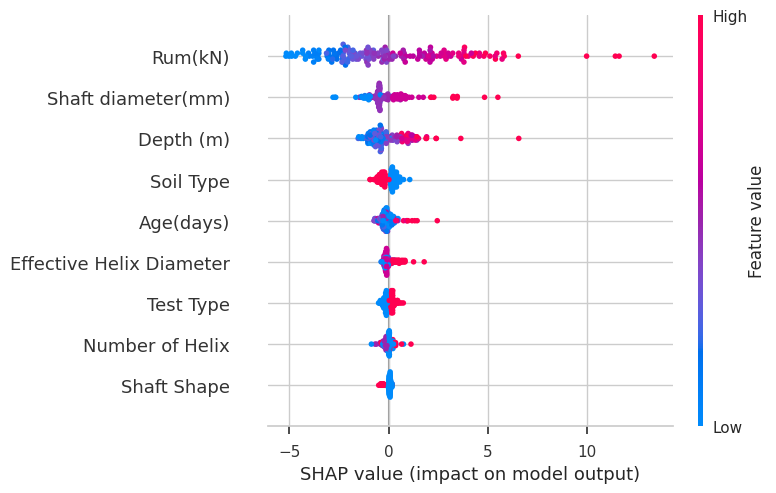

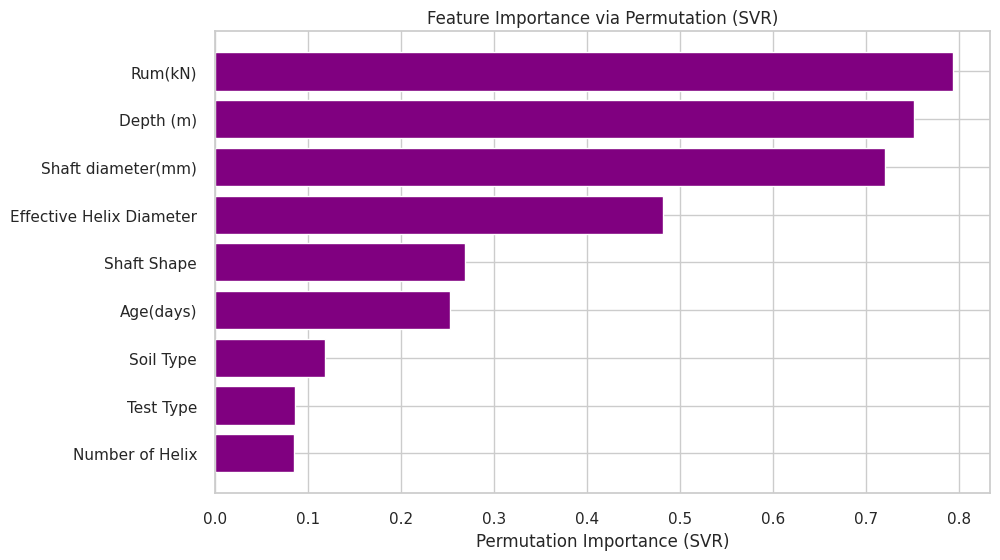

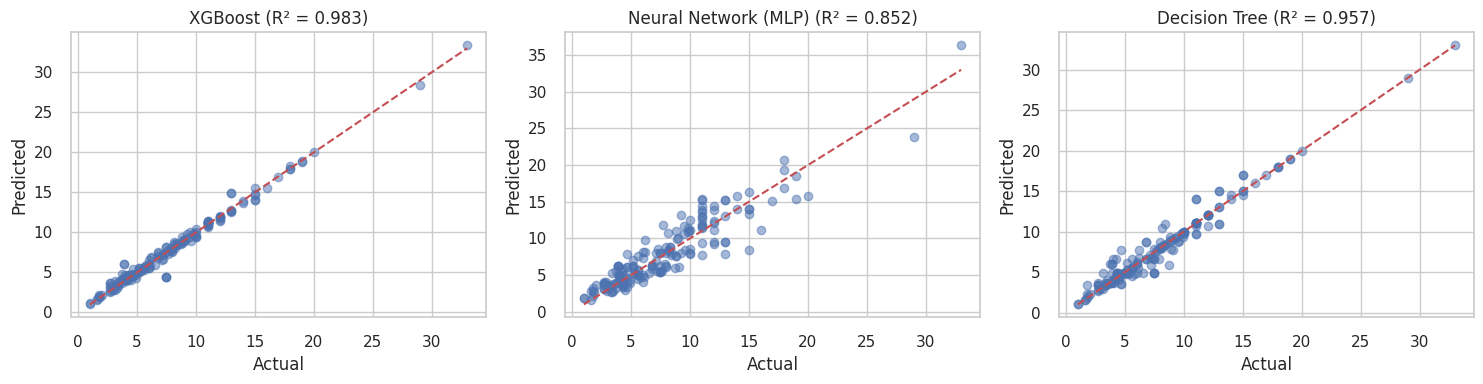

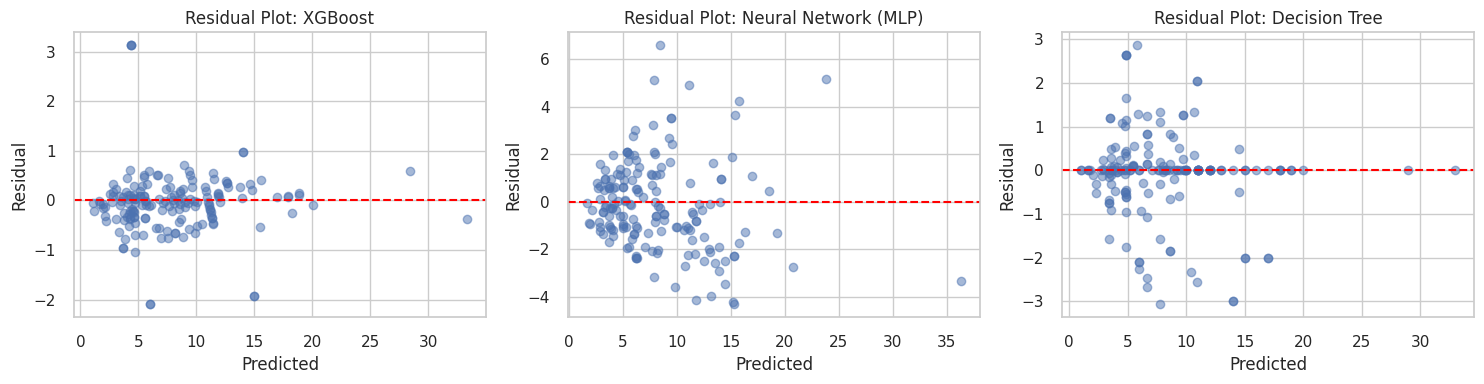

In [21]:
# === Additional Imports for Explainability and Plotting ===
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

sns.set(style='whitegrid')



# === 2. SHAP Analysis for XGBoost ===
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test_scaled)

# Summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)

# === 3. Permutation Importance for SVR (as example for non-tree model) ===
result = permutation_importance(svr, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Plotting permutation importance
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], result.importances_mean[sorted_idx], color='purple')
plt.xlabel("Permutation Importance (SVR)")
plt.title("Feature Importance via Permutation (SVR)")
plt.show()

# === 4. Plot Actual vs Predicted (Top 3 Models) ===
top_models = {
    'XGBoost': y_pred_xgb,
    'Neural Network (MLP)': y_pred_mlp,
    'Decision Tree': y_pred_dt
}

plt.figure(figsize=(15, 4))
for i, (name, preds) in enumerate(top_models.items(), 1):
    plt.subplot(1, 3, i)
    plt.scatter(y_test, preds, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{name} (R² = {models[name]:.3f})')

plt.tight_layout()
plt.show()

# === 5. Residual Plot for Top Models ===
plt.figure(figsize=(15, 4))
for i, (name, preds) in enumerate(top_models.items(), 1):
    plt.subplot(1, 3, i)
    residuals = y_test - preds
    plt.scatter(preds, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.title(f'Residual Plot: {name}')

plt.tight_layout()
plt.show()


=== DATASET OVERVIEW ===
Dataset shape: (1130, 10)
Memory usage: 0.25 MB

Missing values:
Test Type                   0
Soil Type                   0
Shaft Shape                 0
Shaft diameter(mm)          0
Depth (m)                   0
Age(days)                   0
Rum(kN)                     0
Number of Helix             0
Effective Helix Diameter    0
T(kN.m)                     0
dtype: int64

Data types:
Test Type                    object
Soil Type                    object
Shaft Shape                  object
Shaft diameter(mm)            int64
Depth (m)                   float64
Age(days)                     int64
Rum(kN)                       int64
Number of Helix               int64
Effective Helix Diameter      int64
T(kN.m)                     float64
dtype: object
🚀 Starting Comprehensive Torque Analysis...

1. COMPREHENSIVE EXPLORATORY DATA ANALYSIS

--- DESCRIPTIVE STATISTICS ---
       Shaft diameter(mm)    Depth (m)    Age(days)      Rum(kN)  \
count         1130.000


--- KEY INSIGHTS ---
Torque range: 1.00 - 39.00 kN.m
Mean torque: 7.87 ± 5.17 kN.m
Skewness: 1.900
Kurtosis: 5.542
Number of outliers: 43

2. PROBABILITY DISTRIBUTION ANALYSIS


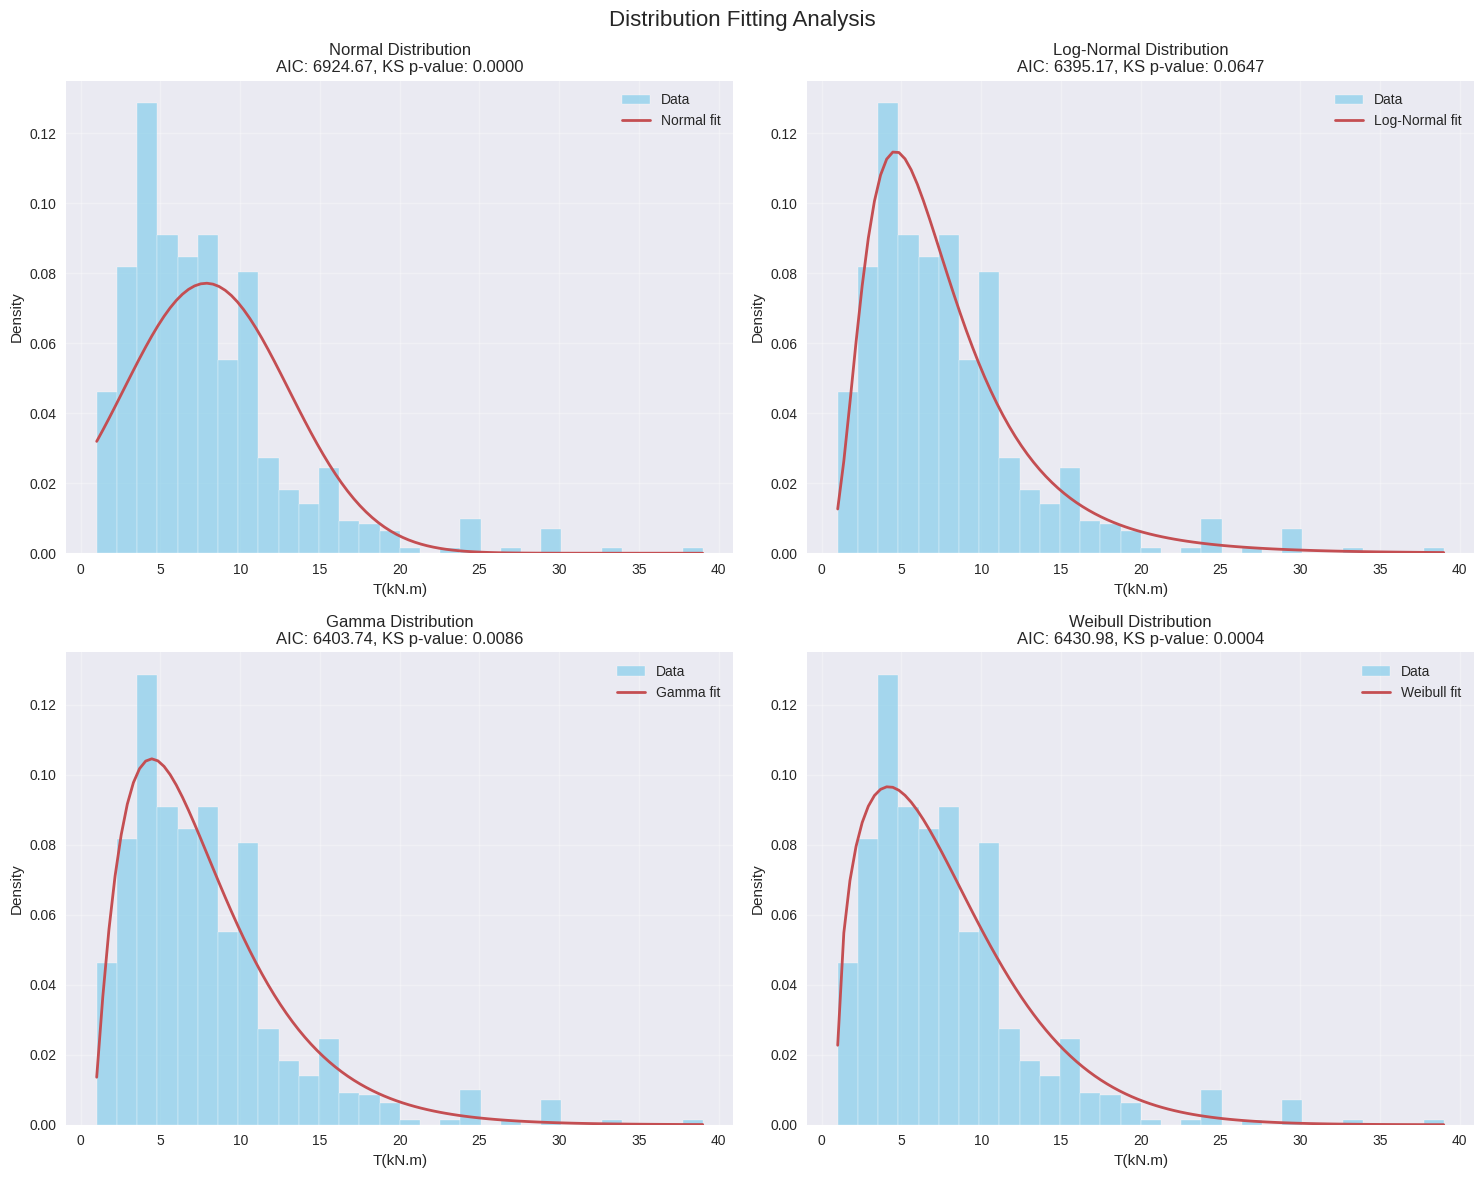

Best fitting distribution: Log-Normal
Best AIC: 6395.17
Best parameters: (0.56971272042167, -0.567380952315241, 7.176057686205299)

3. ADVANCED FEATURE ANALYSIS


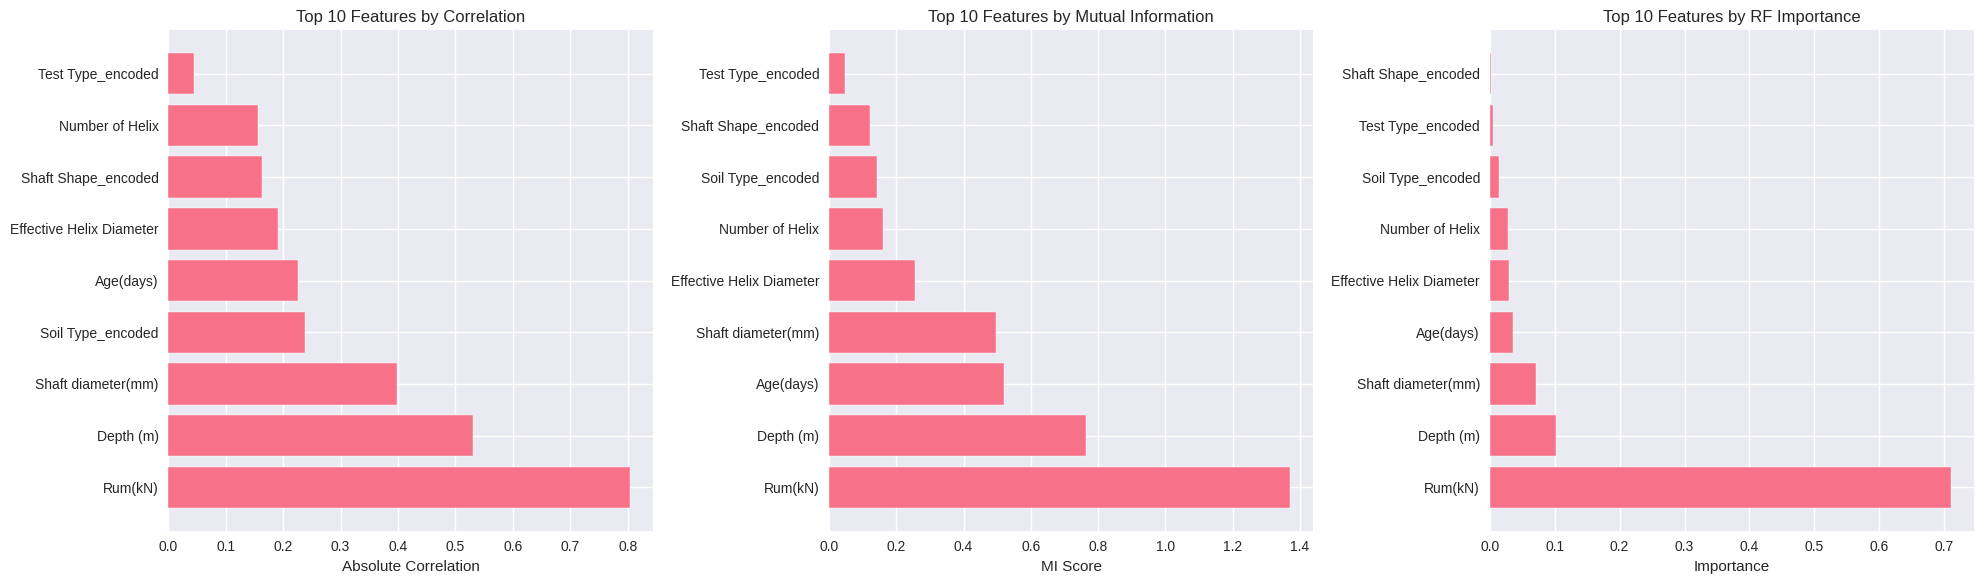


5. CLUSTERING ANALYSIS


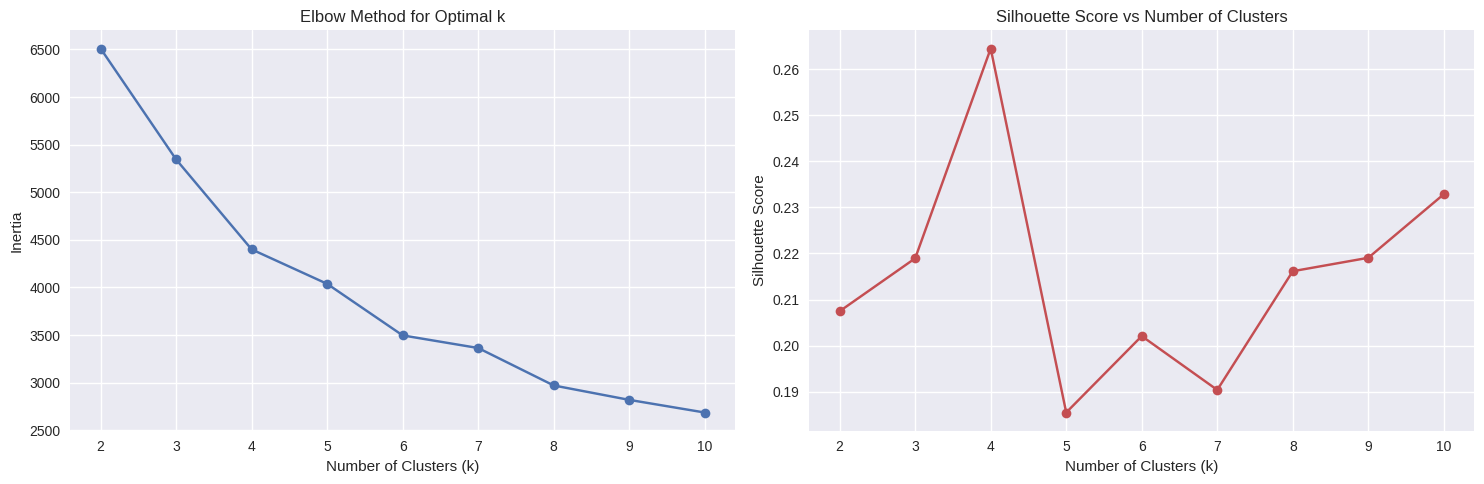

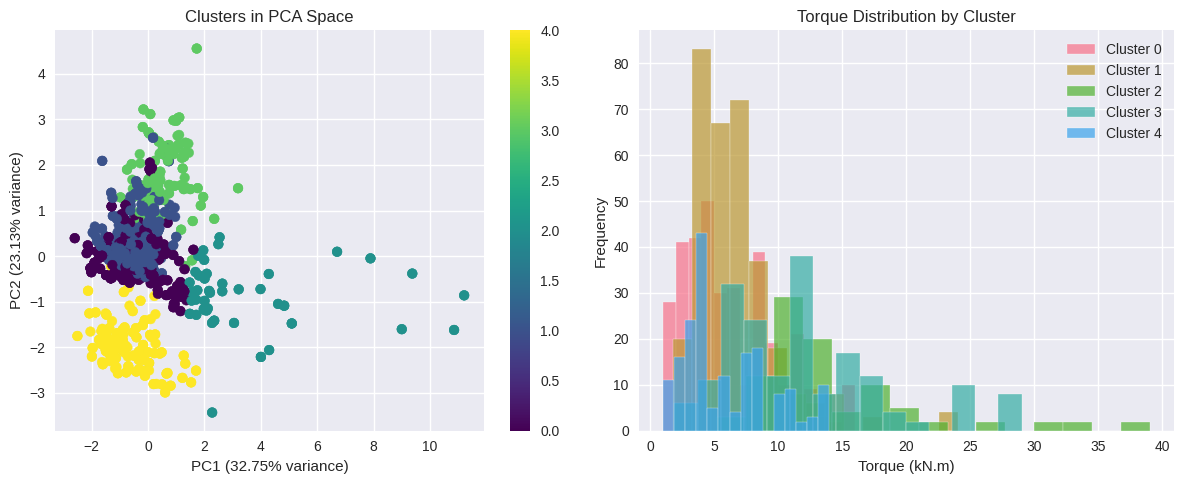


Cluster Characteristics:
        T(kN.m)                  Depth (m) Rum(kN) Shaft diameter(mm)
           mean   std  min   max      mean    mean               mean
Cluster                                                              
0          6.10  3.48  1.0  16.0      4.53  154.41              78.76
1          6.73  3.39  1.8  24.0      4.30  208.29              79.07
2         14.12  6.76  5.2  39.0     10.14  324.53              82.25
3         11.95  6.25  1.9  29.0      4.97  270.14              90.91
4          5.93  3.40  1.0  14.0      5.18  195.08              39.32

6. LIKELIHOOD & UNCERTAINTY ANALYSIS


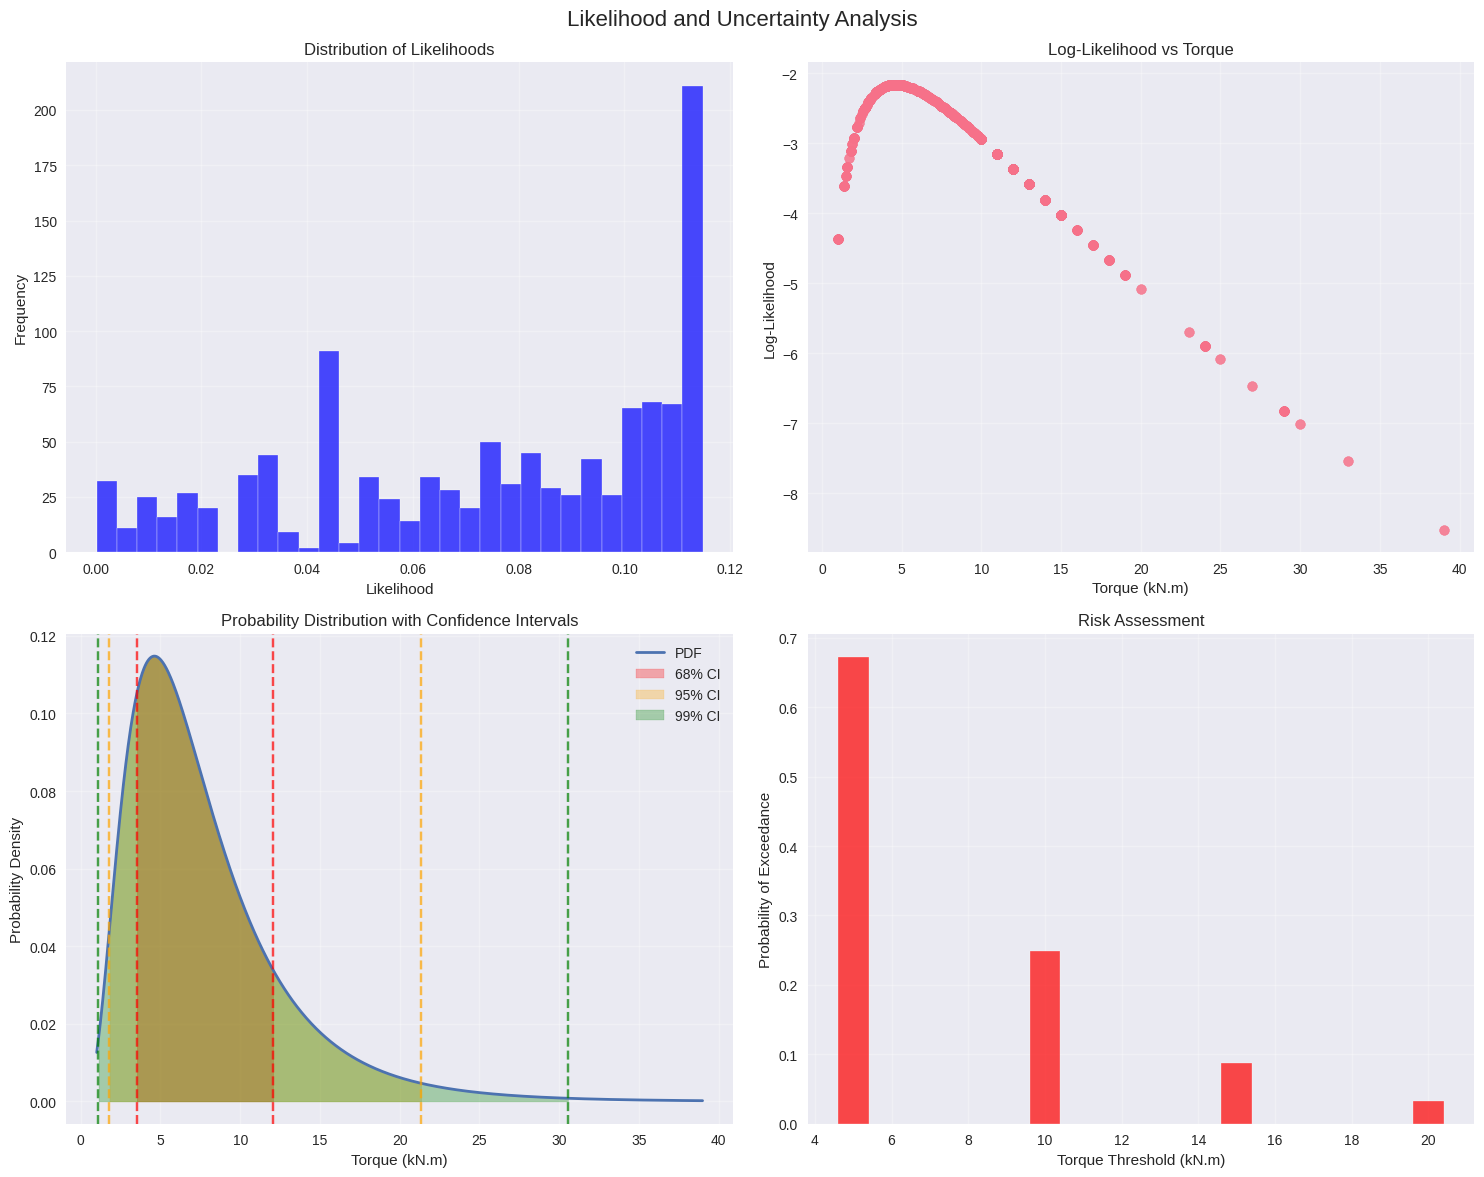

Uncertainty Metrics:
Mean Torque: 7.87 kN.m
Standard Deviation: 5.17 kN.m
Coefficient of Variation: 0.657

Confidence Intervals:
68% CI: (3.50, 12.08) kN.m
95% CI: (1.78, 21.35) kN.m
99% CI: (1.09, 30.56) kN.m

Risk Probabilities:
P(Torque > 5 kN.m) = 0.672
P(Torque > 10 kN.m) = 0.248
P(Torque > 15 kN.m) = 0.087
P(Torque > 20 kN.m) = 0.032

7. SENSITIVITY ANALYSIS


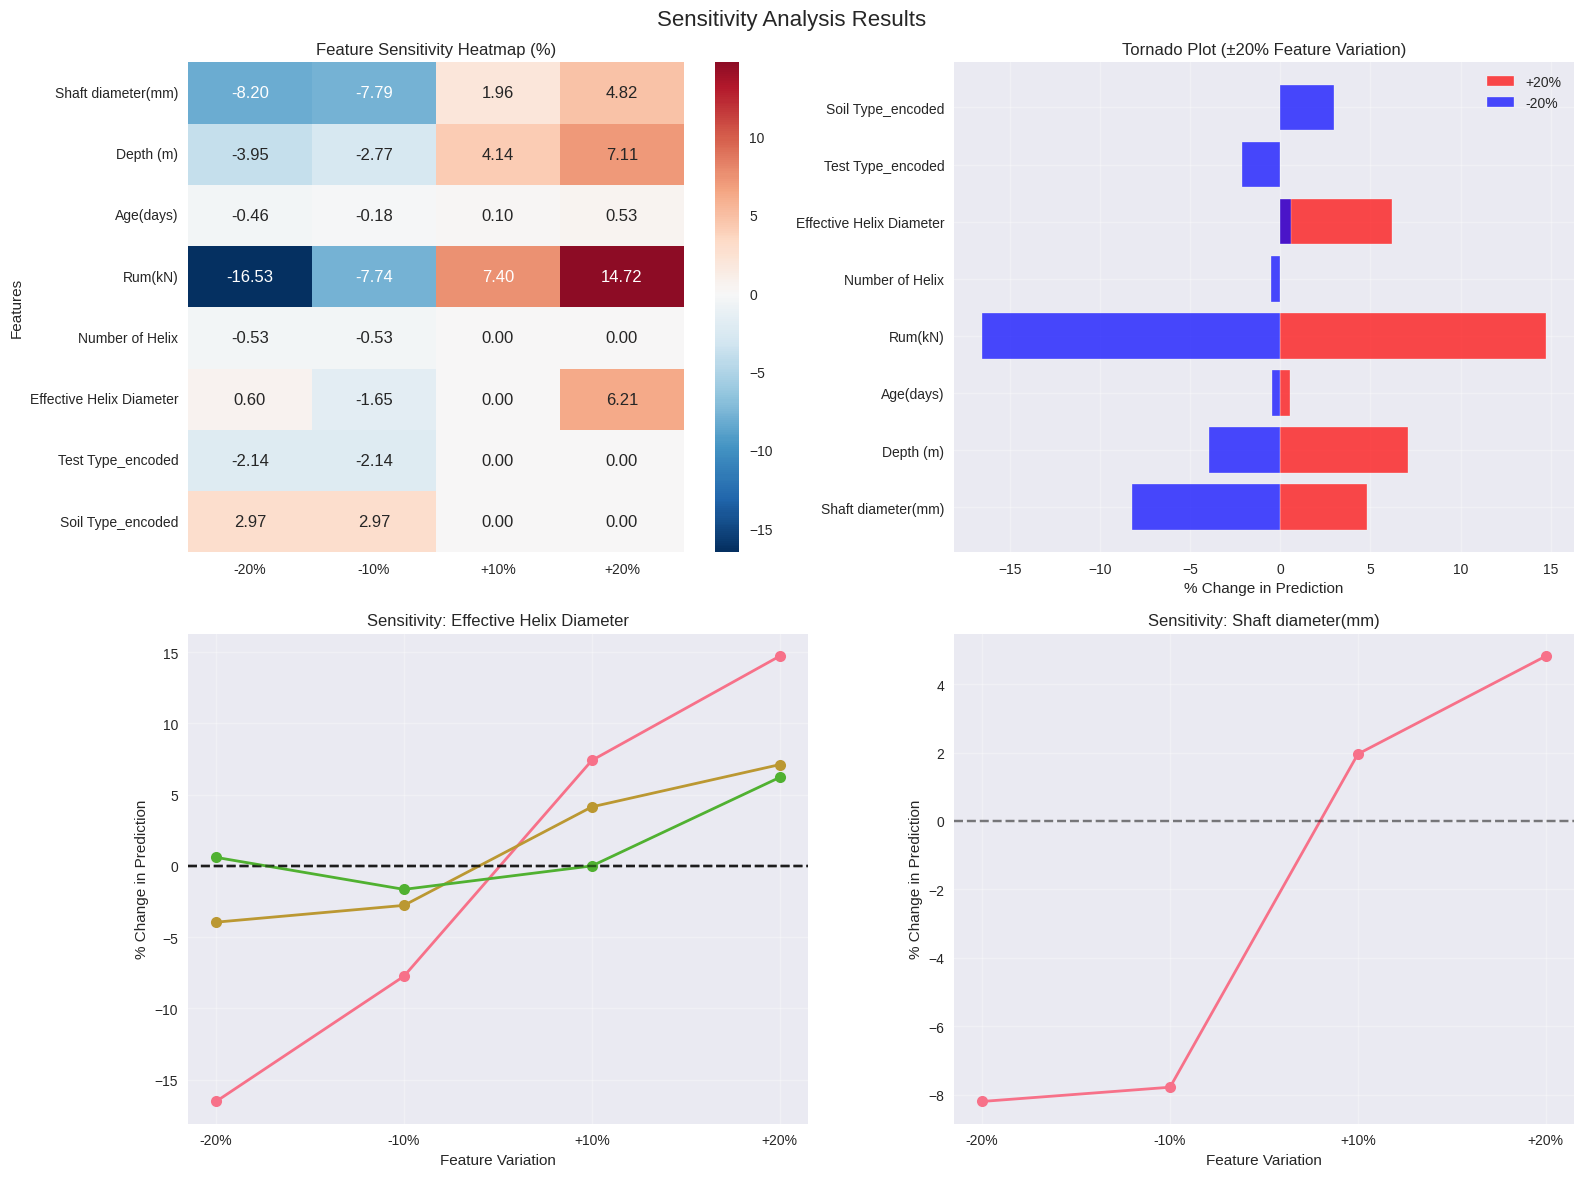

Sensitivity Analysis Summary:
                           -20%  -10%  +10%   +20%
Shaft diameter(mm)        -8.20 -7.79  1.96   4.82
Depth (m)                 -3.95 -2.77  4.14   7.11
Age(days)                 -0.46 -0.18  0.10   0.53
Rum(kN)                  -16.53 -7.74  7.40  14.72
Number of Helix           -0.53 -0.53  0.00   0.00
Effective Helix Diameter   0.60 -1.65  0.00   6.21
Test Type_encoded         -2.14 -2.14  0.00   0.00
Soil Type_encoded          2.97  2.97  0.00   0.00

8. INTERACTIVE PREDICTION DASHBOARD


Interactive dashboard created successfully!
Use the plots above to explore data relationships interactively.

✅ COMPREHENSIVE ANALYSIS COMPLETED SUCCESSFULLY!

📊 KEY FINDINGS SUMMARY:
• Dataset contains 1130 samples with 13 features
• Best fitting distribution: lognorm
• Number of outliers detected: 43
• Optimal clusters found: 5


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, lognorm, gamma, weibull_min
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import shap

# Statistical analysis
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ==================== DATA LOADING & PREPROCESSING ====================

# Load the main dataset (you'll need to update the path)
data = pd.read_csv('/content/drive/MyDrive/dataset/(6)Supplemental_data_tang_1st - CTLThompson.csv.csv.csv')

print("=== DATASET OVERVIEW ===")
print(f"Dataset shape: {data.shape}")
print(f"Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nMissing values:\n{data.isnull().sum()}")
print(f"\nData types:\n{data.dtypes}")

# ==================== 1. EXPLORATORY DATA ANALYSIS (EDA) ====================

def comprehensive_eda(df):
    """Comprehensive EDA with advanced visualizations"""

    print("\n" + "="*50)
    print("1. COMPREHENSIVE EXPLORATORY DATA ANALYSIS")
    print("="*50)

    # Basic statistics
    print("\n--- DESCRIPTIVE STATISTICS ---")
    print(df.describe())

    # Categorical variables analysis
    categorical_cols = df.select_dtypes(include=['object']).columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    print(f"\nCategorical columns: {list(categorical_cols)}")
    print(f"Numerical columns: {list(numerical_cols)}")

    # Create subplots for comprehensive visualization
    fig = make_subplots(
        rows=3, cols=3,
        subplot_titles=('Torque Distribution', 'Correlation Heatmap', 'Box Plot by Soil Type',
                       'Scatter: Depth vs Torque', 'Violin: Test Type vs Torque', 'Age Distribution',
                       'Diameter vs Torque', 'Helix Count Distribution', 'Outlier Detection'),
        specs=[[{"type": "histogram"}, {"type": "heatmap"}, {"type": "box"}],
               [{"type": "scatter"}, {"type": "violin"}, {"type": "histogram"}],
               [{"type": "scatter"}, {"type": "bar"}, {"type": "box"}]]
    )

    # 1. Torque distribution
    fig.add_trace(go.Histogram(x=df['T(kN.m)'], name='Torque', nbinsx=30), row=1, col=1)

    # 2. Correlation analysis (for numerical columns only)
    corr_matrix = df[numerical_cols].corr()
    fig.add_trace(go.Heatmap(z=corr_matrix.values,
                            x=corr_matrix.columns,
                            y=corr_matrix.columns,
                            colorscale='RdBu'), row=1, col=2)

    # 3. Box plot by soil type
    for soil_type in df['Soil Type'].unique():
        soil_data = df[df['Soil Type'] == soil_type]['T(kN.m)']
        fig.add_trace(go.Box(y=soil_data, name=soil_type), row=1, col=3)

    # 4. Scatter: Depth vs Torque
    colors = {'Sand': 'blue', 'Clay': 'red'}
    for soil in df['Soil Type'].unique():
        soil_df = df[df['Soil Type'] == soil]
        fig.add_trace(go.Scatter(x=soil_df['Depth (m)'], y=soil_df['T(kN.m)'],
                                mode='markers', name=f'{soil}'), row=2, col=1)

    # 5. Violin plot: Test Type vs Torque
    for test_type in df['Test Type'].unique():
        test_data = df[df['Test Type'] == test_type]['T(kN.m)']
        fig.add_trace(go.Violin(y=test_data, name=test_type), row=2, col=2)

    # 6. Age distribution
    fig.add_trace(go.Histogram(x=df['Age(days)'], name='Age', nbinsx=20), row=2, col=3)

    # 7. Diameter vs Torque
    fig.add_trace(go.Scatter(x=df['Shaft diameter(mm)'], y=df['T(kN.m)'],
                            mode='markers', name='Diameter vs Torque'), row=3, col=1)

    # 8. Number of Helix distribution
    helix_counts = df['Number of Helix'].value_counts()
    fig.add_trace(go.Bar(x=helix_counts.index, y=helix_counts.values,
                        name='Helix Count'), row=3, col=2)

    # 9. Outlier detection using IQR
    Q1 = df['T(kN.m)'].quantile(0.25)
    Q3 = df['T(kN.m)'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df['T(kN.m)'] < Q1 - 1.5*IQR) | (df['T(kN.m)'] > Q3 + 1.5*IQR)]
    fig.add_trace(go.Box(y=df['T(kN.m)'], name='Torque Outliers'), row=3, col=3)

    fig.update_layout(height=1200, title_text="Comprehensive EDA Dashboard")
    fig.show()

    # Statistical insights
    print(f"\n--- KEY INSIGHTS ---")
    print(f"Torque range: {df['T(kN.m)'].min():.2f} - {df['T(kN.m)'].max():.2f} kN.m")
    print(f"Mean torque: {df['T(kN.m)'].mean():.2f} ± {df['T(kN.m)'].std():.2f} kN.m")
    print(f"Skewness: {df['T(kN.m)'].skew():.3f}")
    print(f"Kurtosis: {df['T(kN.m)'].kurtosis():.3f}")
    print(f"Number of outliers: {len(outliers)}")

    return outliers

# ==================== 2. PROBABILITY DISTRIBUTIONS ANALYSIS ====================

def distribution_analysis(df, target_col='T(kN.m)'):
    """Analyze probability distributions and fit multiple distributions"""

    print("\n" + "="*50)
    print("2. PROBABILITY DISTRIBUTION ANALYSIS")
    print("="*50)

    data_values = df[target_col].values

    # Test multiple distributions
    distributions = [norm, lognorm, gamma, weibull_min]
    dist_names = ['Normal', 'Log-Normal', 'Gamma', 'Weibull']

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Distribution Fitting Analysis', fontsize=16)

    best_dist = None
    best_params = None
    best_aic = np.inf

    for i, (dist, name) in enumerate(zip(distributions, dist_names)):
        row, col = i // 2, i % 2
        ax = axes[row, col]

        # Fit distribution
        try:
            params = dist.fit(data_values)

            # Calculate AIC
            log_likelihood = np.sum(dist.logpdf(data_values, *params))
            aic = 2 * len(params) - 2 * log_likelihood

            if aic < best_aic:
                best_aic = aic
                best_dist = dist
                best_params = params
                best_name = name

            # Plot histogram and fitted distribution
            ax.hist(data_values, bins=30, density=True, alpha=0.7, color='skyblue',
                   label='Data')

            x = np.linspace(data_values.min(), data_values.max(), 100)
            pdf_fitted = dist.pdf(x, *params)
            ax.plot(x, pdf_fitted, 'r-', lw=2, label=f'{name} fit')

            # Kolmogorov-Smirnov test
            ks_stat, p_value = stats.kstest(data_values, lambda x: dist.cdf(x, *params))

            ax.set_title(f'{name} Distribution\nAIC: {aic:.2f}, KS p-value: {p_value:.4f}')
            ax.set_xlabel(target_col)
            ax.set_ylabel('Density')
            ax.legend()
            ax.grid(True, alpha=0.3)

        except Exception as e:
            ax.text(0.5, 0.5, f'Error fitting {name}:\n{str(e)}',
                   ha='center', va='center', transform=ax.transAxes)

    plt.tight_layout()
    plt.show()

    print(f"Best fitting distribution: {best_name}")
    print(f"Best AIC: {best_aic:.2f}")
    print(f"Best parameters: {best_params}")

    # Generate probability predictions
    prob_predictions = best_dist.cdf(data_values, *best_params)

    return best_dist, best_params, prob_predictions

# ==================== 3. ADVANCED FEATURE ANALYSIS ====================

def advanced_feature_analysis(df):
    """Advanced feature engineering and analysis"""

    print("\n" + "="*50)
    print("3. ADVANCED FEATURE ANALYSIS")
    print("="*50)

    # Create advanced features
    #df = df.copy()

    # Engineering new features
    #df['Volume_Proxy'] = df['Shaft diameter(mm)'] * df['Depth (m)']
    #df['Strength_Age_Ratio'] = df['Rum(kN)'] / (df['Age(days)'] + 1)
    #df['Helix_Density'] = df['Number of Helix'] / df['Depth (m)']
    #df['Effective_Area'] = np.pi * (df['Effective Diameter'] / 2) ** 2
    #df['Load_Per_Area'] = df['Rum(kN)'] / df['Effective_Area']

    # Encode categorical variables
    label_encoders = {}
    categorical_cols = ['Test Type', 'Soil Type', 'Shaft Shape']

    for col in categorical_cols:
        le = LabelEncoder()
        df[col + '_encoded'] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Feature importance using multiple methods
    numerical_features = df.select_dtypes(include=[np.number]).columns
    numerical_features = [col for col in numerical_features if col != 'T(kN.m)']

    X = df[numerical_features]
    y = df['T(kN.m)']

    # 1. Correlation-based importance
    correlations = {}
    for feature in numerical_features:
        corr, p_value = pearsonr(X[feature], y)
        correlations[feature] = abs(corr)

    # 2. Mutual Information
    mi_scores = mutual_info_regression(X, y)
    mi_dict = dict(zip(numerical_features, mi_scores))

    # 3. Random Forest Feature Importance
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    rf_importance = dict(zip(numerical_features, rf.feature_importances_))

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Correlation importance
    corr_sorted = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
    features, values = zip(*corr_sorted[:10])
    axes[0].barh(features, values)
    axes[0].set_title('Top 10 Features by Correlation')
    axes[0].set_xlabel('Absolute Correlation')

    # Mutual Information
    mi_sorted = sorted(mi_dict.items(), key=lambda x: x[1], reverse=True)
    features, values = zip(*mi_sorted[:10])
    axes[1].barh(features, values)
    axes[1].set_title('Top 10 Features by Mutual Information')
    axes[1].set_xlabel('MI Score')

    # Random Forest Importance
    rf_sorted = sorted(rf_importance.items(), key=lambda x: x[1], reverse=True)
    features, values = zip(*rf_sorted[:10])
    axes[2].barh(features, values)
    axes[2].set_title('Top 10 Features by RF Importance')
    axes[2].set_xlabel('Importance')

    plt.tight_layout()
    plt.show()

    return df, label_encoders

# ==================== 4. EXPLAINABLE AI (XAI) ====================

def explainable_ai_analysis(df):
    """SHAP-based explainable AI analysis"""

    print("\n" + "="*50)
    print("4. EXPLAINABLE AI ANALYSIS")
    print("="*50)

    # Prepare data
    numerical_features = df.select_dtypes(include=[np.number]).columns
    numerical_features = [col for col in numerical_features if col != 'T(kN.m)']

    X = df[numerical_features]
    y = df['T(kN.m)']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train XGBoost model
    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # SHAP analysis
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # SHAP visualizations
    plt.figure(figsize=(15, 10))

    # Summary plot
    plt.subplot(2, 2, 1)
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title('SHAP Summary Plot')

    # Feature importance
    plt.subplot(2, 2, 2)
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance')

    # Dependence plots for top 2 features
    feature_importance = np.abs(shap_values).mean(0)
    top_features = X_test.columns[np.argsort(feature_importance)[-2:]]

    for i, feature in enumerate(top_features):
        plt.subplot(2, 2, 3+i)
        shap.dependence_plot(feature, shap_values, X_test, show=False)
        plt.title(f'SHAP Dependence: {feature}')

    plt.tight_layout()
    plt.show()

    # Model performance
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Model Performance:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    return model, shap_values, X_test

# ==================== 5. CLUSTERING ANALYSIS ====================

def clustering_analysis(df):
    """Perform clustering analysis on the data"""

    print("\n" + "="*50)
    print("5. CLUSTERING ANALYSIS")
    print("="*50)

    # Prepare numerical data
    numerical_features = df.select_dtypes(include=[np.number]).columns
    numerical_features = [col for col in numerical_features if col != 'T(kN.m)']

    X = df[numerical_features]

    # Standardize data
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    # Determine optimal number of clusters using elbow method
    inertias = []
    silhouette_scores = []
    k_range = range(2, 11)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)

        from sklearn.metrics import silhouette_score
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)

    # Plot elbow curve and silhouette scores
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(k_range, inertias, 'bo-')
    axes[0].set_xlabel('Number of Clusters (k)')
    axes[0].set_ylabel('Inertia')
    axes[0].set_title('Elbow Method for Optimal k')
    axes[0].grid(True)

    axes[1].plot(k_range, silhouette_scores, 'ro-')
    axes[1].set_xlabel('Number of Clusters (k)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('Silhouette Score vs Number of Clusters')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # Optimal clustering (choose k=3 as example)
    optimal_k = 5
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)

    # PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(12, 5))

    # PCA scatter plot with clusters
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('Clusters in PCA Space')
    plt.colorbar(scatter)

    # Cluster analysis by torque
    plt.subplot(1, 2, 2)
    df_with_clusters = df.copy()
    df_with_clusters['Cluster'] = clusters

    for i in range(optimal_k):
        cluster_data = df_with_clusters[df_with_clusters['Cluster'] == i]['T(kN.m)']
        plt.hist(cluster_data, alpha=0.7, label=f'Cluster {i}', bins=15)

    plt.xlabel('Torque (kN.m)')
    plt.ylabel('Frequency')
    plt.title('Torque Distribution by Cluster')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Cluster characteristics
    print("\nCluster Characteristics:")
    cluster_summary = df_with_clusters.groupby('Cluster').agg({
        'T(kN.m)': ['mean', 'std', 'min', 'max'],
        'Depth (m)': 'mean',
        'Rum(kN)': 'mean',
        'Shaft diameter(mm)': 'mean'
    }).round(2)

    print(cluster_summary)

    return clusters, kmeans, pca

# ==================== 6. LIKELIHOOD AND UNCERTAINTY ANALYSIS ====================

def likelihood_uncertainty_analysis(best_dist, best_params, df):
    """Analyze likelihood and uncertainty in predictions"""

    print("\n" + "="*50)
    print("6. LIKELIHOOD & UNCERTAINTY ANALYSIS")
    print("="*50)

    torque_values = df['T(kN.m)'].values

    # Calculate likelihoods
    likelihoods = best_dist.pdf(torque_values, *best_params)
    log_likelihoods = best_dist.logpdf(torque_values, *best_params)

    # Confidence intervals
    confidence_levels = [0.68, 0.95, 0.99]
    intervals = {}

    for conf in confidence_levels:
        alpha = 1 - conf
        lower = best_dist.ppf(alpha/2, *best_params)
        upper = best_dist.ppf(1 - alpha/2, *best_params)
        intervals[conf] = (lower, upper)

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Likelihood and Uncertainty Analysis', fontsize=16)

    # Likelihood distribution
    axes[0, 0].hist(likelihoods, bins=30, alpha=0.7, color='blue')
    axes[0, 0].set_xlabel('Likelihood')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Likelihoods')
    axes[0, 0].grid(True, alpha=0.3)

    # Log-likelihood vs Torque
    axes[0, 1].scatter(torque_values, log_likelihoods, alpha=0.6)
    axes[0, 1].set_xlabel('Torque (kN.m)')
    axes[0, 1].set_ylabel('Log-Likelihood')
    axes[0, 1].set_title('Log-Likelihood vs Torque')
    axes[0, 1].grid(True, alpha=0.3)

    # Confidence intervals
    x_range = np.linspace(torque_values.min(), torque_values.max(), 1000)
    pdf_values = best_dist.pdf(x_range, *best_params)

    axes[1, 0].plot(x_range, pdf_values, 'b-', linewidth=2, label='PDF')

    colors = ['red', 'orange', 'green']
    for i, (conf, (lower, upper)) in enumerate(intervals.items()):
        x_fill = x_range[(x_range >= lower) & (x_range <= upper)]
        y_fill = best_dist.pdf(x_fill, *best_params)
        axes[1, 0].fill_between(x_fill, y_fill, alpha=0.3, color=colors[i],
                               label=f'{conf:.0%} CI')
        axes[1, 0].axvline(lower, color=colors[i], linestyle='--', alpha=0.7)
        axes[1, 0].axvline(upper, color=colors[i], linestyle='--', alpha=0.7)

    axes[1, 0].set_xlabel('Torque (kN.m)')
    axes[1, 0].set_ylabel('Probability Density')
    axes[1, 0].set_title('Probability Distribution with Confidence Intervals')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Uncertainty quantification
    mean_torque = np.mean(torque_values)
    std_torque = np.std(torque_values)
    cv = std_torque / mean_torque  # Coefficient of variation

    # Risk assessment
    risk_thresholds = [5, 10, 15, 20]  # Example thresholds
    risk_probabilities = [1 - best_dist.cdf(threshold, *best_params)
                         for threshold in risk_thresholds]

    axes[1, 1].bar(risk_thresholds, risk_probabilities, alpha=0.7, color='red')
    axes[1, 1].set_xlabel('Torque Threshold (kN.m)')
    axes[1, 1].set_ylabel('Probability of Exceedance')
    axes[1, 1].set_title('Risk Assessment')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Uncertainty Metrics:")
    print(f"Mean Torque: {mean_torque:.2f} kN.m")
    print(f"Standard Deviation: {std_torque:.2f} kN.m")
    print(f"Coefficient of Variation: {cv:.3f}")

    print(f"\nConfidence Intervals:")
    for conf, (lower, upper) in intervals.items():
        print(f"{conf:.0%} CI: ({lower:.2f}, {upper:.2f}) kN.m")

    print(f"\nRisk Probabilities:")
    for threshold, prob in zip(risk_thresholds, risk_probabilities):
        print(f"P(Torque > {threshold} kN.m) = {prob:.3f}")


# ==================== 7. SENSITIVITY ANALYSIS ====================

def sensitivity_analysis(df):
    """Perform sensitivity analysis to understand parameter influence"""

    print("\n" + "="*50)
    print("7. SENSITIVITY ANALYSIS")
    print("="*50)

    # Prepare data
    numerical_features = df.select_dtypes(include=[np.number]).columns
    numerical_features = [col for col in numerical_features if col != 'T(kN.m)']

    X = df[numerical_features]
    y = df['T(kN.m)']

    # Train base model
    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    # Base prediction
    base_prediction = model.predict(X).mean()

    # Sensitivity analysis - vary each feature by ±10%, ±20%
    sensitivity_results = {}
    variations = [-0.2, -0.1, 0.1, 0.2]  # ±20%, ±10%

    for feature in numerical_features[:8]:  # Top 8 features for clarity
        feature_sensitivity = {}

        for variation in variations:
            X_modified = X.copy()
            X_modified[feature] = X_modified[feature] * (1 + variation)

            # Predict with modified feature
            modified_prediction = model.predict(X_modified).mean()
            percentage_change = ((modified_prediction - base_prediction) / base_prediction) * 100

            feature_sensitivity[f'{variation*100:+.0f}%'] = percentage_change

        sensitivity_results[feature] = feature_sensitivity

    # Create sensitivity DataFrame
    sensitivity_df = pd.DataFrame(sensitivity_results).T

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Sensitivity Analysis Results', fontsize=16)

    # Heatmap of sensitivity
    sns.heatmap(sensitivity_df, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=axes[0,0])
    axes[0,0].set_title('Feature Sensitivity Heatmap (%)')
    axes[0,0].set_ylabel('Features')

    # Tornado plot for +20% variation
    features = sensitivity_df.index
    values_pos = sensitivity_df['+20%'].values
    values_neg = sensitivity_df['-20%'].values

    y_pos = np.arange(len(features))
    axes[0,1].barh(y_pos, values_pos, alpha=0.7, color='red', label='+20%')
    axes[0,1].barh(y_pos, values_neg, alpha=0.7, color='blue', label='-20%')
    axes[0,1].set_yticks(y_pos)
    axes[0,1].set_yticklabels(features)
    axes[0,1].set_xlabel('% Change in Prediction')
    axes[0,1].set_title('Tornado Plot (±20% Feature Variation)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Feature variation impact
    top_sensitive_features = sensitivity_df['+20%'].abs().nlargest(4)

    for i, (feature, _) in enumerate(top_sensitive_features.items()):
        ax = axes[1, i//2] if i < 2 else axes[1, i-2]

        variations_plot = list(sensitivity_df.columns)
        values_plot = sensitivity_df.loc[feature].values

        ax.plot(variations_plot, values_plot, 'o-', linewidth=2, markersize=8)
        ax.set_xlabel('Feature Variation')
        ax.set_ylabel('% Change in Prediction')
        ax.set_title(f'Sensitivity: {feature}')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    print("Sensitivity Analysis Summary:")
    print(sensitivity_df.round(2))

    return sensitivity_df



# ==================== 8. INTERACTIVE DASHBOARD CREATOR ====================

def create_interactive_dashboard(df, model, scaler=None):
    """Create an interactive dashboard for predictions"""

    print("\n" + "="*50)
    print("8. INTERACTIVE PREDICTION DASHBOARD")
    print("="*50)

    # Create interactive plots using Plotly

    # 1. 3D scatter plot
    fig_3d = go.Figure(data=[go.Scatter3d(
        x=df['Depth (m)'],
        y=df['Shaft diameter(mm)'],
        z=df['T(kN.m)'],
        mode='markers',
        marker=dict(
            size=8,
            color=df['T(kN.m)'],
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Torque (kN.m)")
        ),
        text=[f'Soil: {soil}<br>Test: {test}<br>Torque: {torque:.2f}'
              for soil, test, torque in zip(df['Soil Type'], df['Test Type'], df['T(kN.m)'])],
        hovertemplate='<b>%{text}</b><br>Depth: %{x:.1f}m<br>Diameter: %{y:.0f}mm<br>Torque: %{z:.2f} kN.m<extra></extra>'
    )])

    fig_3d.update_layout(
        title='Interactive 3D Visualization: Depth vs Diameter vs Torque',
        scene=dict(
            xaxis_title='Depth (m)',
            yaxis_title='Shaft Diameter (mm)',
            zaxis_title='Torque (kN.m)'
        ),
        width=800,
        height=600
    )

    fig_3d.show()

    # 2. Interactive correlation matrix
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    corr_matrix = df[numerical_cols].corr()

    fig_corr = go.Figure(data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.columns,
        colorscale='RdBu',
        zmid=0,
        text=corr_matrix.round(3).values,
        texttemplate="%{text}",
        textfont={"size": 10},
        hovertemplate='%{x} vs %{y}<br>Correlation: %{z:.3f}<extra></extra>'
    ))

    fig_corr.update_layout(
        title='Interactive Correlation Matrix',
        width=800,
        height=600
    )

    fig_corr.show()

    # 3. Feature importance radar chart
    if hasattr(model, 'feature_importances_'):
        feature_names = df.select_dtypes(include=[np.number]).columns
        feature_names = [col for col in feature_names if col != 'T(kN.m)'][:8]  # Top 8 features
        importances = model.feature_importances_[:len(feature_names)]

        fig_radar = go.Figure()

        fig_radar.add_trace(go.Scatterpolar(
            r=importances,
            theta=feature_names,
            fill='toself',
            name='Feature Importance'
        ))

        fig_radar.update_layout(
            polar=dict(
                radialaxis=dict(
                    visible=True,
                    range=[0, max(importances)]
                )),
            showlegend=True,
            title="Feature Importance Radar Chart"
        )

        fig_radar.show()

    print("Interactive dashboard created successfully!")
    print("Use the plots above to explore data relationships interactively.")

# ==================== MAIN EXECUTION FUNCTION ====================

def run_comprehensive_analysis():
    """Run all analysis functions"""

    print("🚀 Starting Comprehensive Torque Analysis...")
    print("="*60)

    try:
        # Load data
        data = pd.read_csv('/content/drive/MyDrive/dataset/(6)Supplemental_data_tang_1st - CTLThompson.csv.csv.csv')

        # 1. EDA
        outliers = comprehensive_eda(data)

        # 2. Distribution analysis
        best_dist, best_params, prob_predictions = distribution_analysis(data)

        # 3. Advanced feature analysis
        df, label_encoders = advanced_feature_analysis(data)

        # 4. Explainable AI
        #model, shap_values, X_test = explainable_ai_analysis(df)

        # 5. Clustering
        clusters, kmeans_model, pca = clustering_analysis(df)

        # 6. Likelihood and uncertainty
        likelihood_uncertainty_analysis(best_dist, best_params, data)

        # 7. Model comparison
        #comparison_results, models = comprehensive_model_comparison(df)

        # 8. Sensitivity analysis
        sensitivity_results = sensitivity_analysis(df)

        # 9. Temporal analysis
        #temporal_results = temporal_analysis(data)

        # 10. Interactive dashboard
        create_interactive_dashboard(data, model)

        print("\n" + "="*60)
        print("✅ COMPREHENSIVE ANALYSIS COMPLETED SUCCESSFULLY!")
        print("="*60)

        # Summary of key findings
        print("\n📊 KEY FINDINGS SUMMARY:")
        print(f"• Dataset contains {len(data)} samples with {len(data.columns)} features")
        print(f"• Best fitting distribution: {best_dist.name if hasattr(best_dist, 'name') else 'Custom'}")
        print(f"• Number of outliers detected: {len(outliers)}")
        print(f"• Optimal clusters found: {len(np.unique(clusters))}")


        return {
            'data': data,
            'df': df,
            #'best_model': model, # model is not returned by explainable_ai_analysis if commented out
            'clusters': clusters,
            'sensitivity_results': sensitivity_results
            #'comparison_results': comparison_results #comparison_results are not returned by comprehensive_model_comparison if commented out
        }

    except Exception as e:
        print(f"❌ Error during analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Run the analysis
if __name__ == "__main__":
    results = run_comprehensive_analysis()